In [1]:
# encoding: UTF-8

"""
简单配对交易策略模板
"""

from vnpy.trader.vtConstant import EMPTY_STRING, DIRECTION_LONG, DIRECTION_SHORT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)

from collections import defaultdict
import time
import numpy as np
import talib as ta
import math
import datetime
########################################################################
class FishingStrategy(CtaTemplate):
    """配对交易策略"""
    className = 'FishingStrategy'
    author = 'ZhenghangXie'
    productType = 'FUTURE'
    # 策略交易标的
    symbolList = []                 # 初始化为空
    activeSymbol = EMPTY_STRING     # 主动品种
    passiveSymbol = EMPTY_STRING    # 被动品种
    asLongpos = EMPTY_STRING        # 主动品种多仓
    asShortpos = EMPTY_STRING       # 主动品种空仓
    psLongpos = EMPTY_STRING        # 被动品种多仓
    psShortpos = EMPTY_STRING       # 被动品种空仓
    posDict = {}                    # 仓位数据缓存
    eveningDict = {}                # 可平仓量数据缓存
    bondDict = {}                   # 保证金数据缓存
    

    # 策略变量
    posSize = 0
    maxcost = 2  #设置最大成本为20

    # 用于记录上一个onTrade的结果，回测需要赋予初始状态，这里以全部空仓为初始
    alpha=983.54424028776
    beta=-0.4126351702961958
    miu=4.5702730569947736e-14
    gap=4.691560608554322
    
    pos = 0

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'activeSymbol',
                 'passiveSymbol']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']


    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(FishingStrategy, self).__init__(ctaEngine, setting)
        self.symbolList = [self.activeSymbol, self.passiveSymbol]

        # MONGO数据库不支持字段名含有 "." ，需特别处理)
        self.activelong = self.activeSymbol.replace(".","_")+"_LONG"
        self.activeshort = self.activeSymbol.replace(".","_")+"_SHORT"
        self.passivelong = self.passiveSymbol.replace(".","_")+"_LONG"
        self.passiveshort = self.passiveSymbol.replace(".","_")+"_SHORT"

        # 创建K线合成器对象
        self.bgDict = {
            sym: BarGenerator(self.onBar)
            for sym in self.symbolList
        }
        
        # 创建数组容器
        self.amDict = {
            sym: ArrayManager()
            for sym in self.symbolList
        }

        # 创建tick数据缓存容器
        self.tickBufferDict = {
            sym: []
            for sym in self.symbolList
        }
        self.flag=False
        self.spreadBuffer = []
#         self.cost = 0
        self.midPassiveBuffer=[]
        self.midActiveBuffer=[]
#         self.miuBuffer=[]
#         self.gapBuffer=[]
#         self.tickDateBuffer=[]
#         self.intervalBuffer=[]
#         self.startTimeBuffer=[]
#         self.endTimeBuffer=[]
#         self.alphaBuffer=[]
        self.current_capital=10000
        self.order_miu_gapMap={}
    
        self.active_passiveMap={}
        
#         self.passive_flagMap={}
        self.passive_countMap={}
        self.passiveIDBuffer=[]
    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' % self.name)
        self.ctaEngine.initPosition(self)
        self.max_volume=int(1)
        self.miu_gapList=[]
#         if not self.posDict:
#             for symbolPos in [self.activelong,self.activeshort,self.passivelong,self.passiveshort]:
#                 self.posDict[symbolPos]=0
        self.putEvent()

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' % self.name)
        self.current_volume=0
        self.putEvent()

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' % self.name)
        self.putEvent()
        print(self.spreadBuffer)

    # ----------------------------------------------------------------------
    def timeToDate(self,time):
        return datetime.fromtimestamp(time)
    
    
    def onTick(self, tick):
        """收到行情TICK推送"""
        self.bgDict[tick.vtSymbol].updateTick(tick)
        self.tickBufferDict[tick.vtSymbol].append(tick)
        #保证两边都有数据才开始进行后面的交易
        if not self.tickBufferDict[self.activeSymbol]:
            return 
        if not self.tickBufferDict[self.passiveSymbol]:
            return
        if len(self.tickBufferDict[self.activeSymbol])>=20000 and len(self.tickBufferDict[self.passiveSymbol])>=20000:
            del self.tickBufferDict[self.activeSymbol][:-5000]
            del self.tickBufferDict[self.passiveSymbol][:-5000]
        #流动性差的品种的bid1和ask1的均值作为计算spread的价格
        midPassive=(self.tickBufferDict[self.passiveSymbol][-1].askPrice1+self.tickBufferDict[self.passiveSymbol][-1].bidPrice1)/2
        #流动性好的品种的bid1和ask1的均值作为计算spread的价格
        midActive=(self.tickBufferDict[self.activeSymbol][-1].askPrice1+self.tickBufferDict[self.activeSymbol][-1].bidPrice1)/2
        #用passive的Buffer存下来midPassive，方便计算均值
        self.midPassiveBuffer.append(midPassive)
        #用active的Buffer存下来midActive，方便计算均值
        self.midActiveBuffer.append(midActive)
        
        #用spread表示价差，但该价差是假定beta=1的时候算出来的，线性回归的sigma（残差）
        spread=midActive-midPassive-self.alpha
        
        #买价-卖价
        abpassive = self.tickBufferDict[self.passiveSymbol][-1].askPrice1 - self.tickBufferDict[self.passiveSymbol][-1].bidPrice1
        abactive = self.tickBufferDict[self.activeSymbol][-1].askPrice1 - self.tickBufferDict[self.activeSymbol][-1].bidPrice1
        self.cost = 1/2*(abpassive + abactive)+ \
               2*0.0005*(self.tickBufferDict[self.activeSymbol][-1].lastPrice + self.tickBufferDict[self.passiveSymbol][-1].lastPrice)          
        
        self.spreadBuffer.append(spread)
        
        if len(self.spreadBuffer)<5000:
            return 
        elif len(self.spreadBuffer)==5000:
            x=np.array(self.midPassiveBuffer[-4000:])
            y=np.array(self.midActiveBuffer[-4000:])
            self.gap=0.0055*np.mean(x+y)/2
            self.beta=1
            self.alpha=float(np.mean(y)-self.beta*np.mean(x))
#             print("第一次的alpha %s和第一次的miu %s,gap %s"%(self.alpha,self.gapBuffer[-1],self.miuBuffer[-1]))
        if len(self.spreadBuffer)<10000:
            return 
        elif len(self.spreadBuffer)%5000==0:
            
            x=np.array(self.midPassiveBuffer[-4000:])
            y=np.array(self.midActiveBuffer[-4000:])
            self.gap=0.0055*np.mean(x+y)/2
            self.beta=1
            self.alpha=float(np.mean(y)-self.beta*np.mean(x))
            self.miu=np.mean(self.spreadBuffer[-4000:])
            
        if len(self.spreadBuffer)==25000:
            del self.midPassiveBuffer[:-10000]
            print("数组长度",len(self.midPassiveBuffer))
            del self.spreadBuffer[:-10000]
            del self.midActiveBuffer[:-10000]
#         print("self.passiveIDBuffer,",self.passiveIDBuffer)
        #self.passiveIDBuffer是存了passiveID，在限价单发出时的单号，但是会在限价单成交或者限价单被注销后remove。
        for passiveID in self.passiveIDBuffer:
            self.passive_countMap[passiveID]+=1
            #每个限价单存在时间是20个tick
            if self.passive_countMap[passiveID]==20:
                self.cancelOrder(passiveID)
                

                
        #如果passive的仓位加上正在挂单的passive的仓位要小于限定的最大仓位
        if self.posDict[self.passivelong]+self.posDict[self.passiveshort]+len(self.passiveIDBuffer)<self.max_volume:                
            if spread>self.miu+self.gap:
                if self.cost<self.maxcost:#如果可以开仓，判断交易成本是否满足条件
                    print('self.pos:%s,spread:%s'%(self.pos,spread))
                    print("activeSymbol bidPrice1 %s"%(self.tickBufferDict[self.activeSymbol][-1].bidPrice1))
                    print("passiveSymbol askPrice1 %s"%(self.tickBufferDict[self.passiveSymbol][-1].askPrice1))
                    print("activeSymbol midPrice %s"%midActive)
                    print("passiveSymbol midPrice %s"%midPassive)
                    
                    passiveID=self.buy(self.passiveSymbol,midPassive,1,marketPrice=0)[0]
                    self.passiveIDBuffer.append(passiveID)
                    
#                     print(type(buyID))
#                     shortID=self.short(self.activeSymbol,1,1)[0]
#                     self.order_statusMap[buyID]="未成交"
#                     self.order_statusMap[shortID]="未成交"
                    
                    self.passive_countMap[passiveID]=0
#                     self.passiveIDBuffer.append(passiveID)
                    print("发单时候的buyID",passiveID)
#                     print("发单时候的shortID",shortID)
        
                    #把ID和miu、gap关联起来为了查询状态成功后append到list里
                    self.order_miu_gapMap[passiveID]=(self.miu,self.gap)
#                     self.order_miu_gapMap[shortID]=(self.miu,self.gap)
                    #为了查到对应单完成交易
#                     self.miu_gap_orderMap[(self.miu,self.gap)]=buyID
#                     self.miu_gap_orderMap[(self.miu,self.gap)]=shortID
                    #映射buyID和shortID为了比较buyID和shortID对应的是不是都已经成交了
#                     self.buy_shortMap[buyID]=shortID
#                     self.short_buyMap[shortID]=buyID
#                     self.order_statusMap[buyID]="未成交"
#                     self.order_statusMap[shortID]="未成交"
#                     print("发单时候的buyID",buyID)
#                     print("发单时候的shortID",shortID)
#                     startTime=tick.localTime
#                     self.startTimeBuffer.append(startTime)
                    
#                     print(self.tickDateBuffer)
            elif spread<self.miu-self.gap:
                if self.cost<self.maxcost:
                    print('self.pos:%s,spread:%s'%(self.pos,spread))
                    print("activeSymbol askPrice1 %s"%(self.tickBufferDict[self.activeSymbol][-1].askPrice1))
                    print("passiveSymbol bidPrice1 %s"%(self.tickBufferDict[self.passiveSymbol][-1].bidPrice1))
                    print("activeSymbol midPrice %s"%midActive)
                    print("passiveSymbol midPrice %s"%midPassive)
                
#                     startTime=tick.localTime
#                     self.startTimeBuffer.append(startTime)
                    
                    #限价单
                    passiveID=self.short(self.passiveSymbol,midPassive,1,marketPrice=0)[0]
#                     buyID=self.buy(self.activeSymbol,9999,1)[0]
#                     self.order_statusMap[shortID]="未成交"
                    self.passiveIDBuffer.append(passiveID)
                    
                    self.passive_countMap[passiveID]=0
#                     self.order_statusMap[buyID]="未成交"
#                     self.order_miu_gapMap[buyID]=(self.miu,self.gap)
                    self.order_miu_gapMap[passiveID]=(self.miu,self.gap)
                    #为了查到对应单完成交易
#                     self.miu_gap_orderMap[(self.miu,self.gap)]=buyID
#                     self.miu_gap_orderMap[(self.miu,self.gap)]=shortID
                    #映射buyID和shortID为了比较buyID和shortID对应的是不是都已经成交了
#                     self.buy_shortMap[buyID]=shortID
#                     self.short_buyMap[shortID]=buyID

#                     self.miu_gapList.append((self.miu,self.gap))
                    
#                     print(self.tickDateBuffer)
        
            
                
                
        
        #如果有仓，判断是否离场
        
        elif self.cost<self.maxcost:
            posDict=self.posDict.copy()
#             print("*"*10)
#             print("此次进入循环的仓位")
#             print("active long",self.posDict[self.activelong])
#             print("passive long",self.posDict[self.passivelong])
#             print("active short",self.posDict[self.activeshort])
#             print("passive short",self.posDict[self.passiveshort])
#             print("self.miu_gapList",self.miu_gapList)
            for i in range(len(self.miu_gapList)):
                miu=self.miu_gapList[i][0]
                gap=self.miu_gapList[i][1]
                flag=self.miu_gapList[i][2]
                pos=self.miu_gapList[i][4]
                if flag:
                    if posDict[self.passivelong]>=1 and posDict[self.activeshort]>=1 and pos==1:
                        if spread<miu-0.5*gap or spread>miu+4*self.gap or self.miu>miu+gap:
                            print('self.pos:%s,spread:%s'%(self.pos,spread))
                            print("activeSymbol bidPrice1 %s"%(self.tickBufferDict[self.activeSymbol][-1].bidPrice1))
                            print("passiveSymbol askPrice1 %s"%(self.tickBufferDict[self.passiveSymbol][-1].askPrice1))
                            print("activeSymbol midPrice %s"%midActive)
                            print("passiveSymbol midPrice %s"%midPassive)

                            passiveID=self.sell(self.passiveSymbol,midPassive,1,marketPrice=0)[0]
                            self.miu_gapList[i][2]=False
                            self.miu_gapList[i][3]=passiveID
                            self.miu_gapList[i][4]=0
                            self.passiveIDBuffer.append(passiveID)
    #                         buyID=self.cover(self.activeSymbol,9999,1)[0]
    #                         self.order_statusMap[shortID]="未成交"
    #                         self.order_statusMap[buyID]="未成交"
    #                         print("交易时候的passive long",self.posDict[self.passivelong])
    #                         print("交易时候的active short",self.posDict[self.activeshort])
    #                         print('shortID:%s, buyID:%s'%(shortID,buyID))
    #                         posDict[self.activeshort]-=1
                            posDict[self.passivelong]-=1
    #                         self.miu_gapList.remove((miu,gap))

                            self.order_miu_gapMap[passiveID]=(miu,gap)

                            self.passive_countMap[passiveID]=0
    #                         self.order_miu_gapMap[shortID]=(miu,gap)
                            #为了查到对应单完成交易
    #                         self.miu_gap_orderMap[(self.miu,self.gap)]=buyID
    #                         self.miu_gap_orderMap[(self.miu,self.gap)]=shortID
                            #映射buyID和shortID为了比较buyID和shortID对应的是不是都已经成交了
    #                         self.buy_shortMap[buyID]=shortID
    #                         self.short_buyMap[shortID]=buyID

#                             endTime=tick.localTime
#                             self.endTimeBuffer.append(endTime)
#                             interval=self.endTimeBuffer[-1]-self.startTimeBuffer[-1]
#                             self.intervalBuffer.append(interval)
#                             print(interval)

    #                         if spread<miu-0.5*gap:
    #                             print("看跌价差，正常交易")
    #                         if spread>miu+4*gap:
    #                             print("价差向上偏离正常值，强平")
    #                         if self.miuBuffer[-1]>miu+gap:
    #                             print("miu增加到最初的miu+gap，强平")


                    if posDict[self.activelong]>=1 and posDict[self.passiveshort]>=1 and pos==-1:
                        if spread>miu+0.5*gap or spread<miu-4*gap or self.miu<miu-gap:
                            print('self.pos:%s,spread:%s'%(self.pos,spread))
                            print("activeSymbol askPrice1 %s"%(self.tickBufferDict[self.activeSymbol][-1].askPrice1))
                            print("passiveSymbol bidPrice1 %s"%(self.tickBufferDict[self.passiveSymbol][-1].bidPrice1))
                            print("activeSymbol midPrice %s"%midActive)
                            print("passiveSymbol midPrice %s"%midPassive)

#                             endTime=tick.localTime
#                             self.endTimeBuffer.append(endTime)
#                             interval=self.endTimeBuffer[-1]-self.startTimeBuffer[-1]
#                             self.intervalBuffer.append(interval)
#                             print(interval)


                            passiveID=self.cover(self.passiveSymbol,midPassive,1,marketPrice=0)[0]
                            self.miu_gapList[i][2]=False
                            self.miu_gapList[i][3]=passiveID
                            self.miu_gapList[i][4]=0
    #                         shortID=self.sell(self.activeSymbol,1,1)[0]
                            posDict[self.passiveshort]-=1
                            self.passiveIDBuffer.append(passiveID)
                            self.passive_countMap[passiveID]=0
    #                         posDict[self.activelong]-=1
    #                         self.order_statusMap[buyID]="未成交"
    #                         self.order_statusMap[shortID]="未成交"
                            self.order_miu_gapMap[passiveID]=(miu,gap)
    #                         self.order_miu_gapMap[shortID]=(miu,gap)
                            #为了查到对应单完成交易
    #                         self.miu_gap_orderMap[(self.miu,self.gap)]=buyID
    #                         self.miu_gap_orderMap[(self.miu,self.gap)]=shortID
                            #映射buyID和shortID为了比较buyID和shortID对应的是不是都已经成交了
    #                         self.buy_shortMap[buyID]=shortID
    #                         self.short_buyMap[shortID]=buyID


    #                         self.miu_gapList.remove((miu,gap))

    #                         time.sleep(0.1)
#                             if spread>miu+0.5*gap:
#                                 print("看涨价差，正常交易")
#                             if spread<miu-4*gap:
#                                 print("价差向下偏离正常值，强平")
#                             if self.miuBuffer[-1]<miu-gap:
#                                 print("miu减小到最初的miu-gap，强平")


        self.putEvent()

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.amDict[bar.vtSymbol].updateBar(bar)
#         print(self.spreadBuffer[-1])
        pass

    # ----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
#         self.order_statusMap[order.vtOrderID]=order.status
#         print("order_statusMap")
#         print(self.order_statusMap)
        print("order.status %s order.vtSymbol %s order.vtOrderID %s order.direction %s order.offset %s"%(order.status,order.vtSymbol,order.vtOrderID,order.offset,order.direction))
        if order.status=="未成交":
            pass
        if order.status=="全部成交":
            if order.vtSymbol==self.passiveSymbol:
                passiveID=order.vtOrderID
                print('Buffer1',self.passiveIDBuffer)
                print("passive_countMap1",self.passive_countMap)
                del self.passive_countMap[passiveID]
                self.passiveIDBuffer.remove(passiveID)
                print("del Buffer1",self.passiveIDBuffer)
                print("del passive_countMap1",self.passive_countMap)
                
                
                if order.direction=="多" and order.offset=="开仓":
                    print("市价追开空")
                    activeID=self.short(self.activeSymbol,1,1)[0]
                elif order.direction=="空" and order.offset=="开仓":
                    print("市价追开多")
                    activeID=self.buy(self.activeSymbol,9999,1)[0]
                elif order.direction=="多"  and order.offset=="平仓":
                    print("市价追平多")
                    activeID=self.sell(self.activeSymbol,1,1)[0]
                elif order.direction=="空" and order.offset=="平仓":
                    print("市价追平空")
                    activeID=self.cover(self.activeSymbol,9999,1)[0]
                self.active_passiveMap[activeID]=passiveID
                print('activeID',activeID)
            elif order.vtSymbol==self.activeSymbol:
                passiveID=self.active_passiveMap[order.vtOrderID]
                del self.active_passiveMap[order.vtOrderID]
                if order.offset=="开仓":
                    print("开仓",passiveID,self.order_miu_gapMap[passiveID])
                    if order.direction=="多":
                        self.miu_gapList.append(list(self.order_miu_gapMap[passiveID])+[True,'0',-1])
                    elif order.direction=="空":
                        self.miu_gapList.append(list(self.order_miu_gapMap[passiveID])+[True,'0',1])
                if order.offset=="平仓":
                    print("平仓",passiveID,self.order_miu_gapMap[passiveID])
                    self.miu_gapList.remove(list(self.order_miu_gapMap[passiveID])+[False,passiveID,0])
                    del self.order_miu_gapMap[passiveID]
        if order.status=="已撤销":
            if order.vtSymbol==self.passiveSymbol:
                for i in range(len(self.miu_gapList)):
                    if order.vtOrderID==self.miu_gapList[i][3]:
                        self.miu_gapList[i][2]=True
                        if order.direction=="多":
                            self.miu_gapList[i][4]=-1
                        elif order.direction=="空":
                            self.miu_gapList[i][4]=1
                self.passiveIDBuffer.remove(order.vtOrderID)
                del self.passive_countMap[order.vtOrderID]

                        
            

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        print('symbol:%s, price:%s, direction:%s, offset:%s, spread:%s,  ,cost:%s,datetime:%s'%
              (trade.vtSymbol,trade.price,trade.direction,trade.offset,self.spreadBuffer[-1], self.cost,trade.dt))
        
       
        print("active long",self.posDict[self.activelong])
        print("passive long",self.posDict[self.passivelong])
        print("active short",self.posDict[self.activeshort])
        print("passive short",self.posDict[self.passiveshort])
        print("self.miu_gapList",self.miu_gapList)
    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
if __name__ == '__main__':
    # Step1 Data
    import datetime
    starttime = datetime.datetime.now()
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting

    # 创建回测引擎对象
    engine = BacktestingEngine()

    # 设置回测使用的数据
    engine.setBacktestingMode(engine.TICK_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_Tick_Db')  # 设置使用的历史数据库
    engine.setStartDate('20180726',initDays=0)               # 设置回测用的数据起始日期
    engine.setEndDate('20180820')

    # 配置回测引擎参数
    engine.setSlippage(0)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万1
    engine.setSize(1)         # 设置合约大小
    engine.setPriceTick(0.001)    # 设置股指最小价格变动
    engine.setCapital(10000)  # 设置回测本金


    # 在引擎中创建策略对象
    d = {'activeSymbol':'bch_quarter.OKEX', 'passiveSymbol':'bch_next_week.OKEX'}                  # 策略参数配置
    engine.initStrategy(FishingStrategy, d)    # 创建策略对象
    
    engine.runBacktesting()
#     print(FishingStrategy.intervalBuffer)

2018-08-22 10:05:59.187503	开始回测
2018-08-22 10:05:59.187503	策略初始化
2018-08-22 10:05:59.187503	载入历史数据。数据范围:[20180726,20180726)
2018-08-22 10:05:59.190503	策略初始化完成
2018-08-22 10:05:59.190503	策略启动完成
2018-08-22 10:05:59.190503	开始回放回测数据,回测范围:[20180726,20180821)
2018-08-22 10:05:59.190503	载入历史数据。数据范围:[20180726,20180727)
2018-08-22 10:06:45.604158	载入完成，数据量：429123
2018-08-22 10:06:45.630159	当前回放数据:[20180726,20180727)
数组长度 10000 10:06:45.902175	Progress: 5%    
数组长度 10000 10:06:46.155189	Progress: 9%    
数组长度 10000 10:06:46.341200	Progress: 12%    
数组长度 10000 10:06:46.586214	Progress: 16%    
数组长度 10000 10:06:46.809227	Progress: 19%    
数组长度-08-22 10:06:47.064241	Progress: 23%     10000
数组长度 10000 10:06:47.248252	Progress: 26%    
数组长度-08-22 10:06:47.502266	Progress: 30%     10000
数组长度-08-22 10:06:47.693277	Progress: 33%     10000
数组长度 10000 10:06:47.942291	Progress: 37%    
数组长度-08-22 10:06:48.119302	Progress: 40%     10000
数组长度 10000 10:06:48.367316	Progress: 44%    
数组长度 10000 10:06:48.569327	P

数组长度 10000 10:08:26.567932	Progress: 1%    
数组长度 10000 10:08:26.779945	Progress: 4%    
数组长度 10000 10:08:27.147966	Progress: 8%    
数组长度 10000 10:08:27.333976	Progress: 11%    
数组长度 10000 10:08:27.655995	Progress: 15%    
数组长度 10000 10:08:27.898009	Progress: 18%    
数组长度 10000 10:08:28.115021	Progress: 21%    
数组长度 10000 10:08:28.426039	Progress: 25%    
数组长度 10000 10:08:28.683053	Progress: 28%    
数组长度 10000 10:08:28.979070	Progress: 32%    
数组长度 10000 10:08:29.206083	Progress: 35%    
数组长度 10000 10:08:29.511101	Progress: 39%    
数组长度 10000 10:08:29.718113	Progress: 42%    
数组长度 10000 10:08:29.988128	Progress: 46%    
数组长度 10000 10:08:30.228142	Progress: 49%    
数组长度 10000 10:08:30.465155	Progress: 52%    
数组长度 10000 10:08:30.794174	Progress: 56%    
数组长度 10000 10:08:31.100192	Progress: 59%    
数组长度 10000 10:08:31.529216	Progress: 63%    
数组长度 10000 10:08:31.820233	Progress: 66%    
数组长度 10000 10:08:32.277259	Progress: 70%    
数组长度 10000 10:08:32.576276	Progress: 73%    
数组长度 10000 10

数组长度 10000
self.pos:0,spread:0.4263750000000073 38%    
activeSymbol bidPrice1 834
passiveSymbol askPrice1 822
activeSymbol midPrice 834.0
passiveSymbol midPrice 822.0
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 20 order.direction 平仓 order.offset 空
symbol:bch_next_week.OKEX, price:822.0, direction:空, offset:平仓, spread:0.4263750000000073,  ,cost:1.656928,datetime:2018-07-30 09:11:06.455000
active long 0
passive long 0
active short 1
passive short 0
self.miu_gapList [[-4.10462499999989, 4.54079071875, False, '20', 0]]
order.status 全部成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 20 order.direction 平仓 order.offset 空
Buffer1 ['20']
passive_countMap1 {'20': 1}
del Buffer1 []
del passive_countMap1 {}
市价追平空
activeID 21
order.status 未成交 order.vtSymbol bch_quarter.OKEX order.vtOrderID 21 order.direction 平仓 order.offset 多
symbol:bch_quarter.OKEX, price:834, direction:多, offset:平仓, spread:0.4263750000000073,  ,cost:1.656928,datetime:2018-07-30 09:11:06.693000
active l

self.pos:0,spread:-5.276625000000081 91%    
activeSymbol askPrice1 775
passiveSymbol bidPrice1 766
activeSymbol midPrice 775.0
passiveSymbol midPrice 766.0
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 31 order.direction 开仓 order.offset 空
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 31 order.direction 开仓 order.offset 空
self.pos:0,spread:-5.276625000000081
activeSymbol askPrice1 774
passiveSymbol bidPrice1 765
activeSymbol midPrice 774.0
passiveSymbol midPrice 765.0
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 32 order.direction 开仓 order.offset 空
symbol:bch_next_week.OKEX, price:765.0, direction:空, offset:开仓, spread:-5.276625000000081,  ,cost:1.5408130000000002,datetime:2018-07-31 22:02:56.561000
active long 0
passive long 0
active short 0
passive short 1
self.miu_gapList []
order.status 全部成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 32 order.direction 开仓 order.offset 空
Buffer1 ['32']
passive_countMap1 {'32': 2}
d

数组长度 10000 10:12:18.237183	Progress: 45%    
数组长度-08-22 10:12:18.474197	Progress: 49%     10000
数组长度 10000 10:12:18.652207	Progress: 52%    
数组长度-08-22 10:12:18.824217	Progress: 55%     10000
数组长度-08-22 10:12:19.064230	Progress: 59%     10000
数组长度 10000 10:12:19.238240	Progress: 62%    
数组长度 10000 10:12:19.414251	Progress: 65%    
数组长度 10000 10:12:19.645264	Progress: 69%    
数组长度 10000 10:12:19.819274	Progress: 72%    
数组长度 10000 10:12:19.989283	Progress: 75%    
数组长度 10000 10:12:20.160293	Progress: 78%    
数组长度 10000 10:12:20.392306	Progress: 82%    
数组长度 10000 10:12:20.563316	Progress: 85%    
数组长度-08-22 10:12:20.735326	Progress: 88%     10000
数组长度 10000 10:12:20.963339	Progress: 92%    
数组长度 10000 10:12:21.138349	Progress: 95%    
数组长度 10000 10:12:21.309359	Progress: 98%    
2018-08-22 10:12:21.427366	载入历史数据。数据范围:[20180802,20180803)
2018-08-22 10:13:10.771188	载入完成，数据量：437165
2018-08-22 10:13:11.446227	当前回放数据:[20180802,20180803)
数组长度 10000 10:13:11.609236	Progress: 2%    
数组长度 10000 

数组长度 10000 10:14:11.078637	Progress: 69%    
数组长度 10000 10:14:11.337652	Progress: 73%    
数组长度 10000 10:14:11.534663	Progress: 76%    
数组长度 10000 10:14:11.781678	Progress: 80%    
数组长度 10000 10:14:11.965688	Progress: 83%    
数组长度 10000 10:14:12.149699	Progress: 86%    
数组长度 10000 10:14:12.397713	Progress: 90%    
数组长度 10000 10:14:12.592724	Progress: 93%    
数组长度 10000 10:14:12.847739	Progress: 97%    
2018-08-22 10:14:13.039750	载入历史数据。数据范围:[20180804,20180805)
2018-08-22 10:14:58.303338	载入完成，数据量：406167
2018-08-22 10:14:58.969377	当前回放数据:[20180804,20180805)
数组长度 10000 10:14:58.969377	Progress: 0%    
数组长度 10000 10:14:59.278394	Progress: 4%    
数组长度 10000 10:14:59.465405	Progress: 7%    
数组长度 10000 10:14:59.715419	Progress: 11%    
数组长度 10000 10:14:59.950433	Progress: 15%    
数组长度 10000 10:15:00.127443	Progress: 18%    
数组长度 10000 10:15:00.358456	Progress: 22%    
数组长度 10000 10:15:00.575468	Progress: 26%    
数组长度 10000 10:15:00.789481	Progress: 30%    
数组长度 10000 10:15:00.941489	Progress: 

数组长度-08-22 10:16:42.644306	Progress: 23%     10000
self.pos:0,spread:-2.004750000000058
activeSymbol bidPrice1 723
passiveSymbol askPrice1 714
activeSymbol midPrice 723.0
passiveSymbol midPrice 713.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 83 order.direction 平仓 order.offset 空
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 83 order.direction 平仓 order.offset 空
self.pos:0,spread:-2.004750000000058
activeSymbol bidPrice1 723
passiveSymbol askPrice1 714
activeSymbol midPrice 723.0
passiveSymbol midPrice 713.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 84 order.direction 平仓 order.offset 空
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 84 order.direction 平仓 order.offset 空
self.pos:0,spread:-2.004750000000058
activeSymbol bidPrice1 723
passiveSymbol askPrice1 714
activeSymbol midPrice 723.0
passiveSymbol midPrice 713.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 85 order.direction 

self.pos:0,spread:-2.004750000000058 24%    
activeSymbol bidPrice1 722
passiveSymbol askPrice1 713
activeSymbol midPrice 722.0
passiveSymbol midPrice 712.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 113 order.direction 平仓 order.offset 空
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 113 order.direction 平仓 order.offset 空
self.pos:0,spread:-2.004750000000058
activeSymbol bidPrice1 722
passiveSymbol askPrice1 713
activeSymbol midPrice 722.0
passiveSymbol midPrice 712.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 114 order.direction 平仓 order.offset 空
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 114 order.direction 平仓 order.offset 空
self.pos:0,spread:-1.764999999999986425%    
activeSymbol bidPrice1 720
passiveSymbol askPrice1 712
activeSymbol midPrice 720.0
passiveSymbol midPrice 711.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 115 order.direction 平仓 order.offset 空
order.status

数组长度 10000 10:18:29.996447	Progress: 59%    
数组长度 10000 10:18:30.164456	Progress: 62%    
数组长度-08-22 10:18:30.387469	Progress: 66%     10000
数组长度-08-22 10:18:30.552478	Progress: 69%     10000
数组长度 10000 10:18:30.772491	Progress: 73%    
数组长度 10000 10:18:30.965502	Progress: 76%    
数组长度 10000 10:18:31.171514	Progress: 80%    
数组长度 10000 10:18:31.348524	Progress: 83%    
数组长度 10000 10:18:31.559536	Progress: 87%    
数组长度 10000 10:18:31.726546	Progress: 90%    
数组长度 10000 10:18:31.952558	Progress: 94%    
数组长度-08-22 10:18:32.117568	Progress: 97%     10000
2018-08-22 10:18:32.280577	载入历史数据。数据范围:[20180809,20180810)
2018-08-22 10:19:22.512450	载入完成，数据量：432520
2018-08-22 10:19:23.207490	当前回放数据:[20180809,20180810)
数组长度 10000 10:19:23.263493	Progress: 1%    
数组长度 10000 10:19:23.489506	Progress: 4%    
数组长度 10000 10:19:23.706519	Progress: 8%    
数组长度 10000 10:19:23.867528	Progress: 11%    
数组长度 10000 10:19:24.081540	Progress: 15%    
self.pos:0,spread:2.5406249999999773
activeSymbol askPrice1 592


数组长度 10000 10:20:17.335586	Progress: 71%    
数组长度 10000 10:20:17.592601	Progress: 75%    
数组长度 10000 10:20:17.833615	Progress: 79%    
数组长度 10000 10:20:18.086629	Progress: 83%    
数组长度 10000 10:20:18.453650	Progress: 88%    
数组长度-08-22 10:20:18.710665	Progress: 92%     10000
数组长度 10000 10:20:18.946678	Progress: 96%    
2018-08-22 10:20:19.258696	载入历史数据。数据范围:[20180811,20180812)
2018-08-22 10:21:13.884820	载入完成，数据量：418337
2018-08-22 10:21:14.623863	当前回放数据:[20180811,20180812)
数组长度 10000 10:21:14.623863	Progress: 0%    
数组长度 10000 10:21:14.777872	Progress: 3%    
数组长度 10000 10:21:15.029886	Progress: 7%    
数组长度 10000 10:21:15.246898	Progress: 11%    
数组长度 10000 10:21:15.413908	Progress: 14%    
数组长度-08-22 10:21:15.613919	Progress: 18%     10000
self.pos:0,spread:-3.994249999999965421%    
activeSymbol bidPrice1 561
passiveSymbol askPrice1 562
activeSymbol midPrice 561.0
passiveSymbol midPrice 561.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 134 order.direction 平仓 ord

数组长度 10000 10:22:09.529003	Progress: 35%    
self.pos:0,spread:1.930749999999989: 38%    
activeSymbol askPrice1 568
passiveSymbol bidPrice1 562
activeSymbol midPrice 567.5
passiveSymbol midPrice 562.0
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 145 order.direction 平仓 order.offset 多
symbol:bch_next_week.OKEX, price:562.0, direction:多, offset:平仓, spread:1.930749999999989,  ,cost:1.629827,datetime:2018-08-12 08:52:39
active long 1
passive long 0
active short 0
passive short 0
self.miu_gapList [[0.24787500000005458, 3.118853375, False, '145', 0]]
order.status 全部成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 145 order.direction 平仓 order.offset 多
Buffer1 ['145']
passive_countMap1 {'145': 0}
del Buffer1 []
del passive_countMap1 {}
市价追平多
activeID 146
order.status 未成交 order.vtSymbol bch_quarter.OKEX order.vtOrderID 146 order.direction 平仓 order.offset 空
symbol:bch_quarter.OKEX, price:567, direction:空, offset:平仓, spread:0.9307499999999891,  ,cost:2.629617,datetime:20

数组长度 10000 10:24:04.353571	Progress: 34%    
self.pos:0,spread:2.103999999999985: 36%    
activeSymbol askPrice1 502
passiveSymbol bidPrice1 499
activeSymbol midPrice 502.0
passiveSymbol midPrice 499.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 158 order.direction 平仓 order.offset 多
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 158 order.direction 平仓 order.offset 多
self.pos:0,spread:2.103999999999985
activeSymbol askPrice1 502
passiveSymbol bidPrice1 499
activeSymbol midPrice 502.0
passiveSymbol midPrice 499.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 159 order.direction 平仓 order.offset 多
order.status 已撤销 order.vtSymbol bch_next_week.OKEX order.vtOrderID 159 order.direction 平仓 order.offset 多
self.pos:0,spread:2.103999999999985
activeSymbol askPrice1 503
passiveSymbol bidPrice1 500
activeSymbol midPrice 503.0
passiveSymbol midPrice 500.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 160 order.direc

数组长度-08-22 10:24:59.458723	Progress: 63%     10000
数组长度 10000 10:24:59.673735	Progress: 67%    
数组长度 10000 10:24:59.852745	Progress: 70%    
数组长度 10000 10:25:00.072758	Progress: 74%    
数组长度 10000 10:25:00.283770	Progress: 78%    
数组长度 10000 10:25:00.440779	Progress: 81%    
数组长度-08-22 10:25:00.650791	Progress: 85%     10000
数组长度 10000 10:25:00.887804	Progress: 89%    
数组长度 10000 10:25:01.141819	Progress: 93%    
数组长度 10000 10:25:01.343830	Progress: 96%    
2018-08-22 10:25:01.577844	载入历史数据。数据范围:[20180816,20180817)
2018-08-22 10:25:52.035730	载入完成，数据量：417605
2018-08-22 10:25:52.722769	当前回放数据:[20180816,20180817)
数组长度 10000 10:25:52.722769	Progress: 0%    
数组长度 10000 10:25:52.940782	Progress: 4%    
数组长度 10000 10:25:53.126792	Progress: 7%    
数组长度-08-22 10:25:53.343805	Progress: 11%     10000
数组长度 10000 10:25:53.502814	Progress: 14%    
数组长度 10000 10:25:53.737827	Progress: 18%    
数组长度 10000 10:25:53.931838	Progress: 21%    
数组长度 10000 10:25:54.247856	Progress: 25%    
数组长度 10000 10:25:54

数组长度 10000 10:27:47.364326	Progress: 47%    
数组长度 10000 10:27:47.574338	Progress: 51%    
self.pos:0,spread:-1.800250000000005552%    
activeSymbol bidPrice1 590
passiveSymbol askPrice1 592
activeSymbol midPrice 590.0
passiveSymbol midPrice 592.0
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 200 order.direction 平仓 order.offset 空
symbol:bch_next_week.OKEX, price:592.0, direction:空, offset:平仓, spread:-0.30025000000000546,  ,cost:1.6829609999999997,datetime:2018-08-18 12:45:59.122000
active long 0
passive long 0
active short 1
passive short 0
self.miu_gapList [[0.09962499999998181, 3.26537475, False, '200', 0]]
order.status 全部成交 order.vtSymbol bch_next_week.OKEX order.vtOrderID 200 order.direction 平仓 order.offset 空
Buffer1 ['200']
passive_countMap1 {'200': 2}
del Buffer1 []
del passive_countMap1 {}
市价追平空
activeID 201
order.status 未成交 order.vtSymbol bch_quarter.OKEX order.vtOrderID 201 order.direction 平仓 order.offset 多
symbol:bch_quarter.OKEX, price:590, direction:多, o

数组长度 10000 10:28:41.630430	Progress: 25%    
数组长度-08-22 10:28:41.803440	Progress: 28%     10000
数组长度-08-22 10:28:41.972450	Progress: 31%     10000
数组长度 10000 10:28:42.191462	Progress: 35%    
数组长度 10000 10:28:42.356472	Progress: 38%    
数组长度 10000 10:28:42.574484	Progress: 42%    
数组长度 10000 10:28:42.739493	Progress: 45%    
数组长度 10000 10:28:42.903503	Progress: 48%    
数组长度 10000 10:28:43.122515	Progress: 52%    
数组长度 10000 10:28:43.288525	Progress: 55%    
数组长度 10000 10:28:43.502537	Progress: 59%    
数组长度-08-22 10:28:43.667547	Progress: 62%     10000
数组长度 10000 10:28:43.885559	Progress: 66%    
数组长度 10000 10:28:44.046568	Progress: 69%    
数组长度 10000 10:28:44.212578	Progress: 72%    
数组长度 10000 10:28:44.427590	Progress: 76%    
数组长度 10000 10:28:44.592599	Progress: 79%    
self.pos:0,spread:-3.418374999999969 82%    
activeSymbol askPrice1 571
passiveSymbol bidPrice1 575
activeSymbol midPrice 571.0
passiveSymbol midPrice 575.5
order.status 未成交 order.vtSymbol bch_next_week.OKEX order.vtO

2018-08-22 10:32:03.576981	计算回测结果
2018-08-22 10:32:03.583981	------------------------------
2018-08-22 10:32:03.583981	第一笔交易：	2018-07-26 14:44:44
2018-08-22 10:32:03.583981	最后一笔交易：	2018-08-20 09:00:01.762000
2018-08-22 10:32:03.583981	总交易次数：	52
2018-08-22 10:32:03.583981	总盈亏：	69.8
2018-08-22 10:32:03.583981	最大回撤: 	-71.57
2018-08-22 10:32:03.583981	平均每笔盈利：	1.34
2018-08-22 10:32:03.583981	平均每笔滑点：	0.0
2018-08-22 10:32:03.583981	平均每笔佣金：	0.67
2018-08-22 10:32:03.583981	胜率		55.77%
2018-08-22 10:32:03.583981	盈利交易平均值	13.11
2018-08-22 10:32:03.583981	亏损交易平均值	-13.49
2018-08-22 10:32:03.583981	盈亏比：	0.97


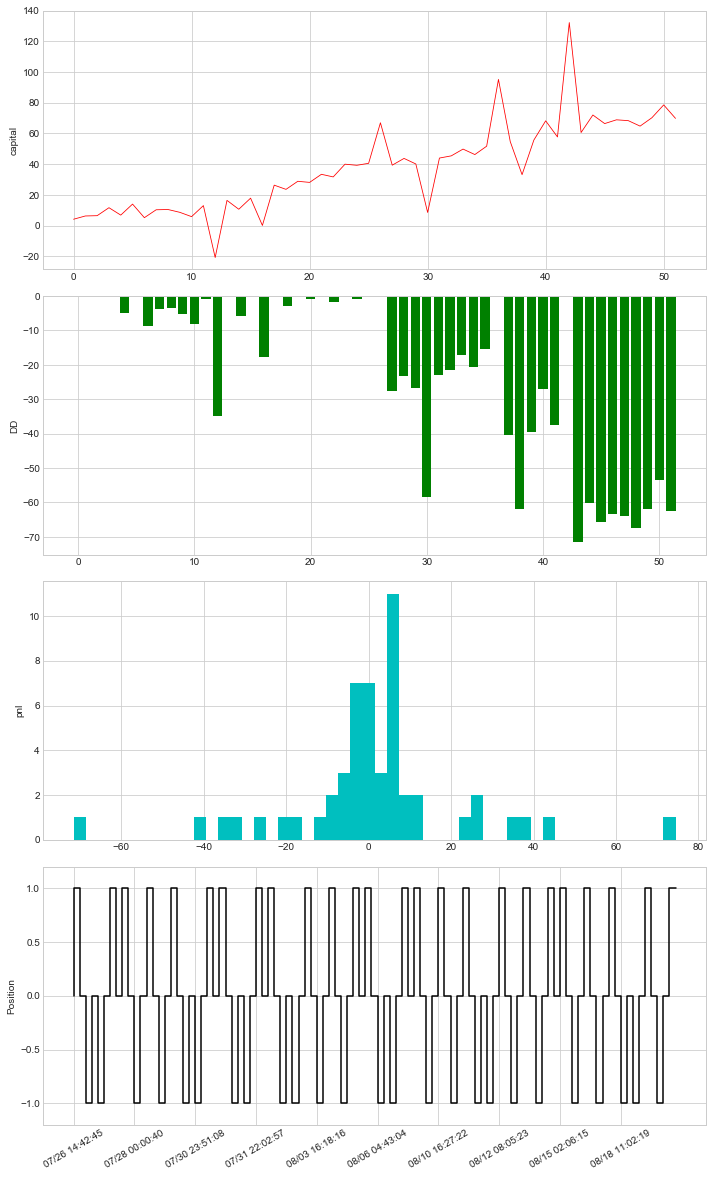

In [3]:
engine.showBacktestingResult()

In [4]:
for i in range(10000):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Symbol:%s, Time: %s, Direction: %s, offset:%s ,Price: %s, Volume: %s' %(d['tradeID'],d['vtSymbol'], d["dt"],d['direction'],d["offset"], d['price'], d['volume']))

TradeID: 1, Symbol:bch_next_week.OKEX, Time: 2018-07-26 14:42:45, Direction: 多, offset:开仓 ,Price: 853.0, Volume: 1
TradeID: 2, Symbol:bch_quarter.OKEX, Time: 2018-07-26 14:42:45.264000, Direction: 空, offset:开仓 ,Price: 873, Volume: 1
TradeID: 3, Symbol:bch_next_week.OKEX, Time: 2018-07-26 14:44:44, Direction: 空, offset:平仓 ,Price: 858.0, Volume: 1
TradeID: 4, Symbol:bch_quarter.OKEX, Time: 2018-07-26 14:44:44.010000, Direction: 多, offset:平仓 ,Price: 870, Volume: 1
TradeID: 5, Symbol:bch_next_week.OKEX, Time: 2018-07-27 06:38:48, Direction: 空, offset:开仓 ,Price: 805.0, Volume: 1
TradeID: 6, Symbol:bch_quarter.OKEX, Time: 2018-07-27 06:38:48.501000, Direction: 多, offset:开仓 ,Price: 811, Volume: 1
TradeID: 7, Symbol:bch_next_week.OKEX, Time: 2018-07-27 20:04:40.462000, Direction: 多, offset:平仓 ,Price: 804.0, Volume: 1
TradeID: 8, Symbol:bch_quarter.OKEX, Time: 2018-07-27 20:04:40.765000, Direction: 空, offset:平仓 ,Price: 817, Volume: 1
TradeID: 9, Symbol:bch_next_week.OKEX, Time: 2018-07-28 00:00

KeyError: '103'

2018-08-22 10:32:16.366712	计算按日统计结果
2018-08-22 10:32:16.559723	------------------------------
2018-08-22 10:32:16.559723	首个交易日：	2018-07-26
2018-08-22 10:32:16.559723	最后交易日：	2018-08-20
2018-08-22 10:32:16.559723	总交易日：	26
2018-08-22 10:32:16.559723	盈利交易日	18
2018-08-22 10:32:16.559723	亏损交易日：	3
2018-08-22 10:32:16.559723	起始资金：	10000
2018-08-22 10:32:16.559723	结束资金：	10,070.37
2018-08-22 10:32:16.559723	总收益率：	0.7%
2018-08-22 10:32:16.560723	年化收益：	6.5%
2018-08-22 10:32:16.560723	总盈亏：	70.37
2018-08-22 10:32:16.560723	最大回撤: 	-3.7
2018-08-22 10:32:16.560723	百分比最大回撤: -0.04%
2018-08-22 10:32:16.560723	总手续费：	34.35
2018-08-22 10:32:16.560723	总滑点：	0
2018-08-22 10:32:16.560723	总成交金额：	68,704.0
2018-08-22 10:32:16.560723	总成交笔数：	102
2018-08-22 10:32:16.560723	日均盈亏：	2.71
2018-08-22 10:32:16.560723	日均手续费：	1.32
2018-08-22 10:32:16.560723	日均滑点：	0.0
2018-08-22 10:32:16.560723	日均成交金额：	2,642.46
2018-08-22 10:32:16.560723	日均成交笔数：	3.92
2018-08-22 10:32:16.560723	日均收益率：	0.02%
2018-08-22 10:32:16.560723	收益标准差：	0.04

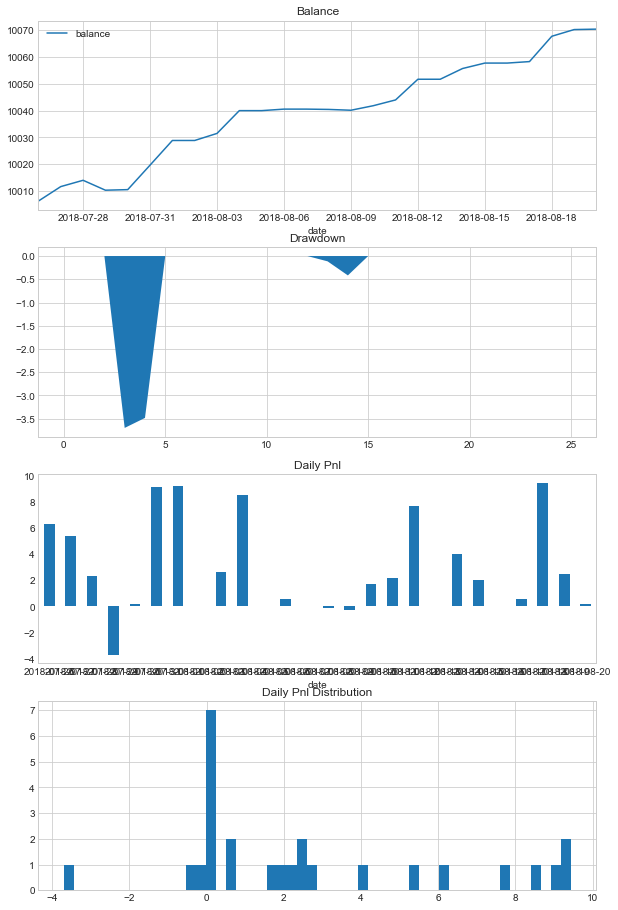

In [5]:
engine.showDailyResult()

In [14]:
import re
import pandas as pd
complier=re.compile("TradeID: (.*?), Symbol:(.*?), Time: (.*?), Direction: (.*?), offset:(.*?) ,Price: (.*?), Volume: 1")
data=[]
with open("data.txt") as f:
    for line in f:
        data.append(complier.findall(line.strip())[0])
        
        df=pd.DataFrame(data,columns=["TradeID","Symbol","Time","Direction","offset","Price"])


In [17]:
df.to_excel("trade.xlsx")